In [1]:
import pandas as pd
import numpy as np
apps = pd.read_csv("googleplaystore.csv")             # main metadata file
reviews = pd.read_csv("googleplaystore_user_reviews.csv")  # optional NLP use
apps.head(); apps.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [2]:
# drop rows with rating > 5 (data error) or other obvious corrupt rows
apps = apps[~(apps['Rating'] > 5)]


In [3]:
# Reviews -> int
apps['Reviews'] = apps['Reviews'].astype(int)

# Price -> float (remove $)
apps['Price'] = apps['Price'].str.replace(r'[$,]', '', regex=True).astype(float)

# Installs -> int (remove '+' and commas)
apps['Installs'] = apps['Installs'].astype(str).str.replace(r'[+,]', '', regex=True).astype(int)

# Size -> convert "19M", "200k", "Varies with device" -> bytes or NaN
def size_to_bytes(s):
    if pd.isna(s) or s == 'Varies with device': return np.nan
    s = s.strip()
    if s.endswith('M'):
        return float(s[:-1]) * 1024*1024
    if s.endswith('k'):
        return float(s[:-1]) * 1024
    try:
        return float(s)
    except:
        return np.nan

apps['Size_bytes'] = apps['Size'].apply(size_to_bytes)
apps['Size_MB'] = apps['Size_bytes'] / (1024*1024)


In [4]:
# remove duplicates
apps.drop_duplicates(inplace=True)

# drop rows with nulls in tiny-error columns
apps.dropna(subset=['Category','Type','Genres','Current Ver','Android Ver'], inplace=True)

# create installs bins
bins = [-1,0,10,1000,10000,100000,1_000_000,10_000_000,1_000_000_000]
labels = ['no','Very low','Low','Moderate','More than moderate','High','Very High','Top Notch']
apps['Installs_cat'] = pd.cut(apps['Installs'], bins=bins, labels=labels)

# fill Rating nulls with mean by Installs_cat (or Category)
apps['Rating'] = apps.groupby('Installs_cat')['Rating'].transform(lambda x: x.fillna(x.mean()))
# if still null, fallback to overall mean:
apps['Rating'].fillna(apps['Rating'].mean(), inplace=True)


C:\Users\bindh\AppData\Local\Temp\ipykernel_9448\3828818318.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  apps['Rating'] = apps.groupby('Installs_cat')['Rating'].transform(lambda x: x.fillna(x.mean()))
C:\Users\bindh\AppData\Local\Temp\ipykernel_9448\3828818318.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  apps['Rating'].fil

In [5]:
apps['Is_Free'] = (apps['Price'] == 0).astype(int)
apps['Last Updated'] = pd.to_datetime(apps['Last Updated'])
apps['days_since_update'] = (pd.Timestamp('today') - apps['Last Updated']).dt.days
apps['Primary_Genre'] = apps['Genres'].str.split(';').str[0]
apps['log_reviews'] = np.log1p(apps['Reviews'])
apps['log_installs'] = np.log1p(apps['Installs'])


<Axes: xlabel='Installs_cat', ylabel='Rating'>

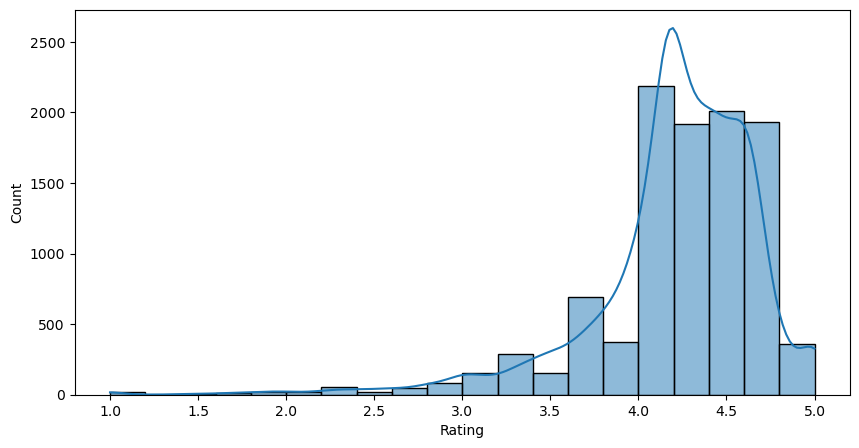

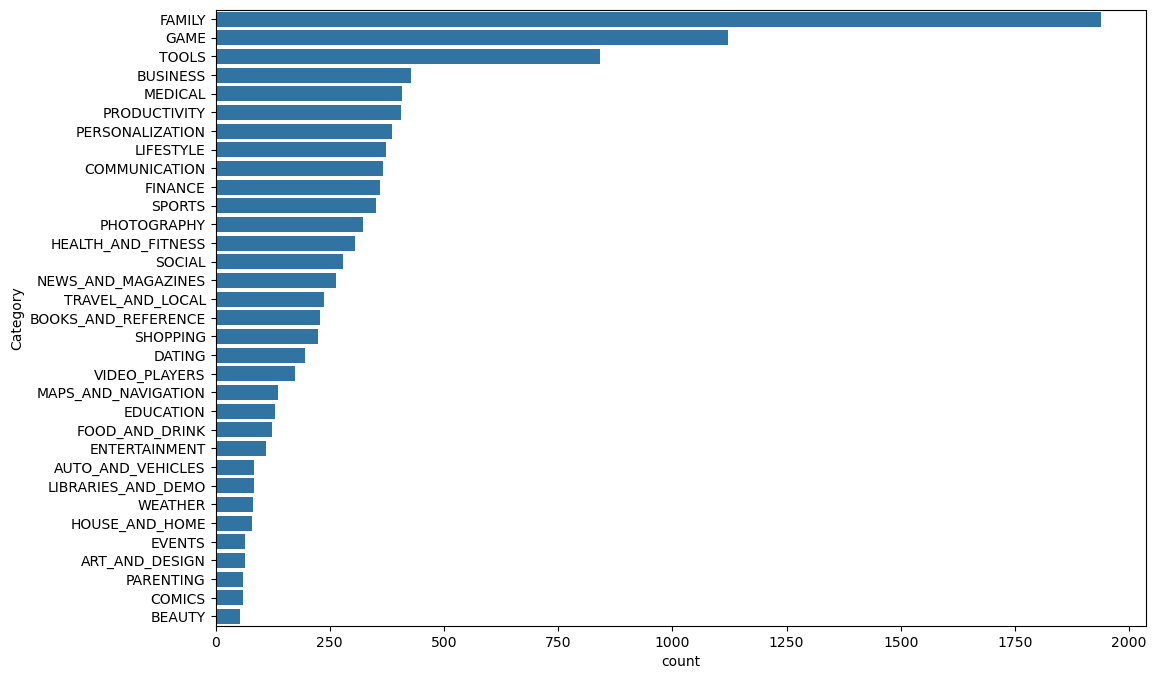

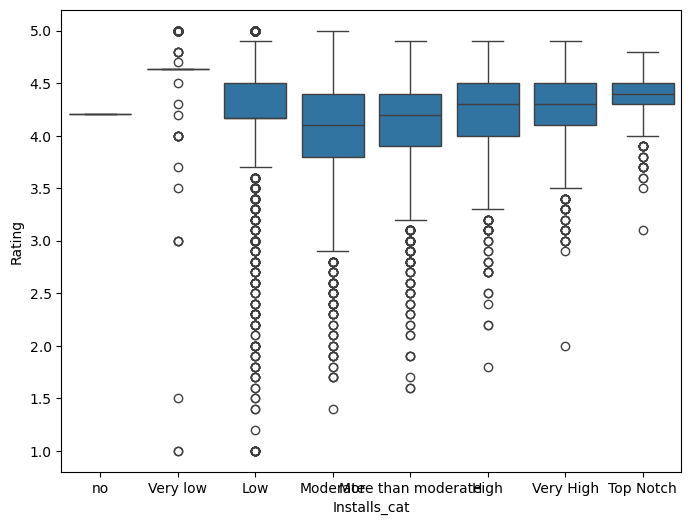

In [6]:
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(10,5)); sns.histplot(apps['Rating'], bins=20, kde=True)

plt.figure(figsize=(12,8)); sns.countplot(y='Category', data=apps, order=apps['Category'].value_counts().index)

plt.figure(figsize=(8,6)); sns.boxplot(x='Installs_cat', y='Rating', data=apps)


In [7]:
from scipy.stats import pearsonr
pearsonr(np.log1p(apps['Reviews']), np.log1p(apps['Installs']))


PearsonRResult(statistic=0.9623959707366466, pvalue=0.0)

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Features
X = apps[['Category','Price','Size_MB','Is_Free','log_reviews','days_since_update']]
y = apps['Rating']

# Define numeric and categorical columns
num_cols = ['Price','Size_MB','log_reviews','days_since_update']
cat_cols = ['Category']

# Preprocessor with imputation
preproc = ColumnTransformer([
  ('num', Pipeline([
      ('imputer', SimpleImputer(strategy='median')),   # fill NaNs with median
      ('scaler', StandardScaler())
  ]), num_cols),
  
  ('cat', Pipeline([
      ('imputer', SimpleImputer(strategy='most_frequent')),  # fill NaNs with most frequent category
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ]), cat_cols)
])

# Final pipeline
pipeline = Pipeline([
  ('pre', preproc),
  ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
pipeline.fit(X_train, y_train)

# Predict
preds = pipeline.predict(X_test)


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print("Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Model Evaluation Metrics:
MAE  : 0.3140
MSE  : 0.2218
RMSE : 0.4710
R²   : 0.0912
